# Regression - SOLUTION
After a first look at simple linear regression, we want to look at more complex details, potential issues, and how to resolve them. In order to focus on certain data science topics, we will use syntethic data for this part.

## Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sklearn as sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Lasso, lasso_path
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

## Generate Data
We define the following function to generate a data set (with `n_samples` many entries). As in the previous notebooks, this function returns a DataFrame, here with the attributes `x` and `y`. We will consider `x` as the independent variable and `y` as the dependent variable throughout the notebook.

The function uses a random generator to generate random values ​​for the `x` values ​​and to introduce noise (e.g. a measurement error) on the `y` values.

In [3]:
def generate_dataset_df(n_samples = 20):
    x = - 4 * np.random.uniform(-1, 1, n_samples)
    y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, n_samples)
    
    dataset_df = pd.DataFrame({ 'x': x, 'y': y})
    return dataset_df

In [4]:
generate_dataset_df(n_samples = 5)

,x,y
0,-2.776690,-36.536689
1,0.607040,-2.580302
2,2.945721,-1.139511
3,-2.759818,-30.593132
4,-3.650112,-59.275436


We now use this function to generate our dataset, which we will split into a training and test data set. We could of course also generate two separate datasets for training and testing separately, but we'll follow this appraoch to see how to split a single given dataset into a training and test set.

As mentioned, the function uses a random generator. This random generator can be initialized with a specific value - the so-called seed. **You should get always set a seed so that the results are reproducible**, i.e. you can run the notebook again later and get the same results. The actual value, however, does not really matter.

In [5]:
np.random.seed(0)

In [6]:
all_data = generate_dataset_df(n_samples=40)

In [7]:
# get a random sample of the data for training
data_train = all_data.sample(frac=0.5, random_state=1)
# gets the left out portion of the dataset
data_test=all_data.drop(data_train.index)

In [8]:
data_train

,x,y
2,-0.822107,-6.495378
31,-2.193870,-25.278461
3,-0.359065,-3.171021
21,-2.393269,-27.244636
27,-3.557351,-55.463765
29,0.682704,-4.169027
22,0.308165,-2.951680
39,-1.454562,-9.837864
19,-2.960097,-35.292186
26,2.853174,-6.717720


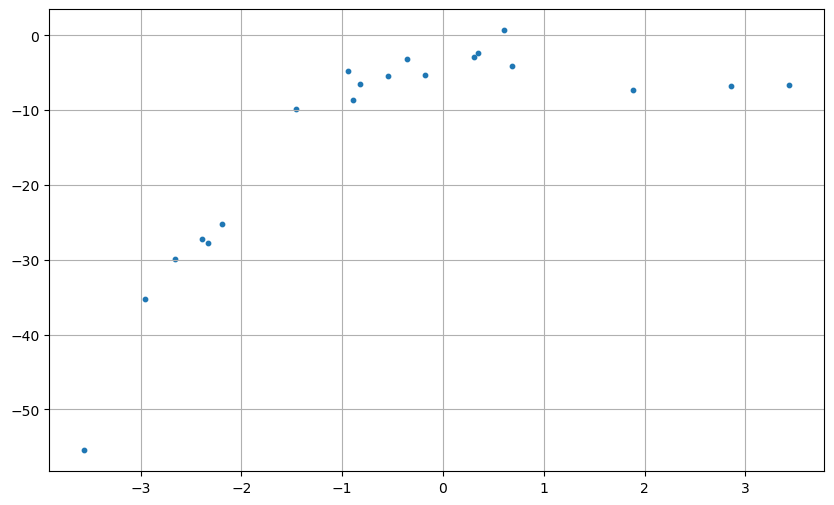

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], s=10)
plt.grid()
plt.show()

## Linear Regression
Again, we define a Regression model. One way to do so is the class `LinearRegression()` from `sklearn.linear_model`, which we have imported above:

In [10]:
linreg_deg1 = LinearRegression()
linreg_deg1.fit(data_train[['x']], data_train['y'])

print('Coefficient: ')
print(linreg_deg1.coef_)
print('Intercept:')
print(linreg_deg1.intercept_)

Coefficient: 
[5.76647847]
Intercept:
-10.47209241661623


Let's plot the training data along with the fitted model:

In [11]:
data_forPlot = pd.DataFrame(np.linspace(-4, 4, num=41), columns = ['x'])
data_forPlot['y_lm_grad01'] = linreg_deg1.predict(data_forPlot[['x']])

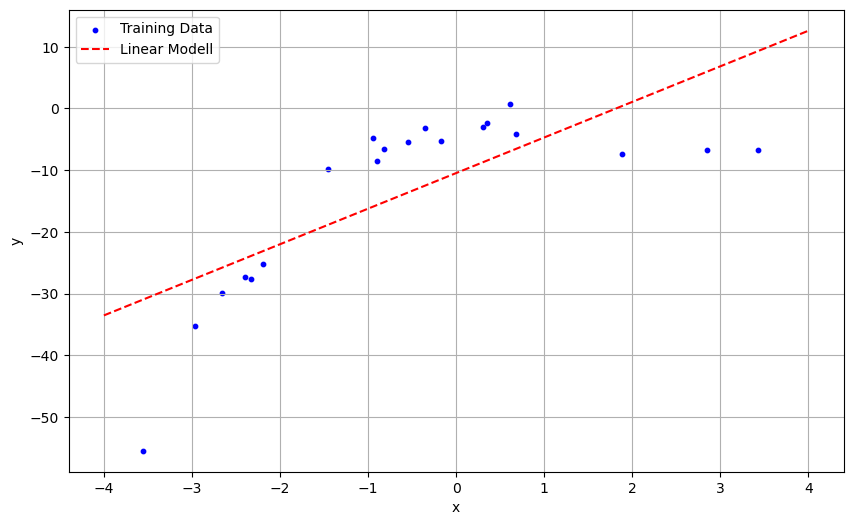

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], 
            label='Training Data', color='b', s=10)
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad01'],
         label = 'Linear Modell',
         linestyle="--", color='r')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.grid()
plt.show()

### Calculate & Visualize Residuals
We define a function to get the prediction from a fitted model and compute the residuum values:

In [13]:
def get_prediction_and_residuum(fitted_model, data_set, y_true):
    y_pred = fitted_model.predict(data_set)
    df_prediction = data_set.copy()
    df_prediction['Prediction'] = y_pred
    df_prediction['Residual'] = y_true - df_prediction['Prediction']
    print('r2-Score: ' + str(r2_score(y_true, y_pred)))
    print('MSE: ' + str(mean_squared_error(y_true, y_pred)))
    print('RMSE: ' + str(root_mean_squared_error(y_true, y_pred)))
    return df_prediction

In [14]:
lm_grad01_pred_res_train = get_prediction_and_residuum(linreg_deg1,
                                                       data_train[['x']],
                                                       data_train['y'])

r2-Score: 0.5503985906607107
MSE: 91.95170173580863
RMSE: 9.5891449950352


We make a plot comparing the predictor values (on the x axis) with the residuum values:

In [15]:
lm_grad01_pred_res_train

,x,Prediction,Residual
2,-0.822107,-15.212755,8.717377
31,-2.193870,-23.122994,-2.155467
3,-0.359065,-12.542636,9.371614
21,-2.393269,-24.272824,-2.971813
27,-3.557351,-30.985482,-24.478283
29,0.682704,-6.535292,2.366265
22,0.308165,-8.695065,5.743385
39,-1.454562,-18.859795,9.021931
19,-2.960097,-27.541429,-7.750757
26,2.853174,5.980672,-12.698392


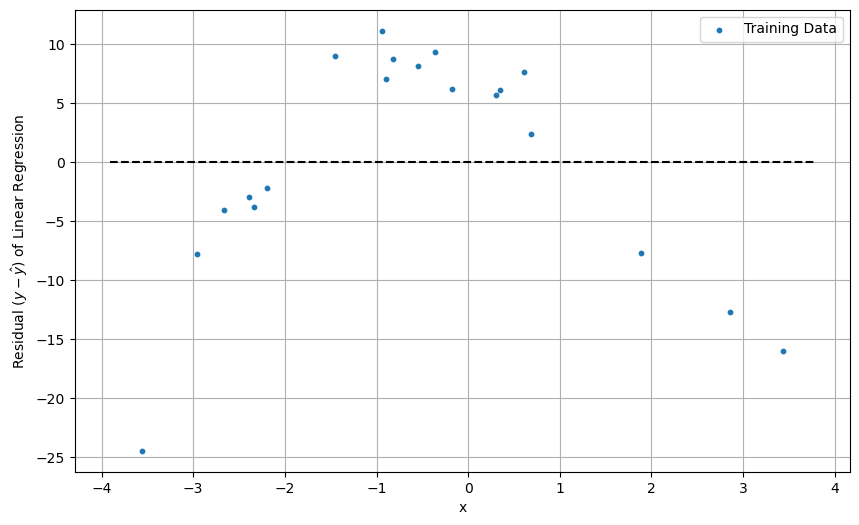

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], lm_grad01_pred_res_train['Residual'],
            label='Training Data', s=10)
plt.legend()

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('Residual ($y-\hat{y}$) of Linear Regression')

plt.plot(plt.xlim(), [0, 0], linestyle="--", color='k')
plt.grid()
plt.show()

We can see a clear structure in these values - for lower values of x, the residuum is alwys negative, in the medium range it is always positive, and for higher values the residuum is negative again. To capture this nonlinear behavior, we define a more complex, non-linear model (in the original values) by defining a regression including the quadratic values of `x`:

## Quadratic Regression
We first do the feature transformation by defining a further feature `x2` as the square of `x`:

In [17]:
data_train['x2'] = data_train['x']**2

In [18]:
linreg_deg2_1 = LinearRegression()
linreg_deg2_1.fit(data_train[['x', 'x2']], data_train['y'])

print('Coefficient: ')
print(linreg_deg2_1.coef_)
print('Intercept:')
print(linreg_deg2_1.intercept_)

Coefficient: 
[ 5.09643632 -2.27730563]
Intercept:
-2.4263624966438417


### Data transformation
The `PolynomialFeatures` from `scikit-learn` uses arrays for the independent and dependent variables - and not DataFrames, as with `statmodels`. We therefore first store the independent variable `x` and the dependent variable `y` as an array, both for the training and test data.

In [19]:
train_x = data_train[['x']]
train_y = data_train[['y']]

test_x = data_test[['x']]
test_y = data_test[['y']]

Now we can produce the polynomial features. We also convert them into a DataFrame, so that we have the same structure as above.

In [20]:
polynomial_features02 = PolynomialFeatures(degree=2)
train_x_poly02 = polynomial_features02.fit_transform(train_x)
train_x_poly02_df = pd.DataFrame(train_x_poly02, columns=['x0', 'x1', 'x2'])

We define a new model `model02` for the quadratic regression:

In [21]:
model02 = LinearRegression()
model02.fit(train_x_poly02_df, train_y)

LinearRegression()

In [22]:
print('Coefficient: ')
print(model02.coef_)
print('Intercept:')
print(model02.intercept_)

Coefficient: 
[[ 0.          5.09643632 -2.27730563]]
Intercept:
[-2.4263625]


As we will be using this functionality over and over again, we pack it into a function:

In [23]:
def print_coeff_and_intercept(model):
    print("Model Coefficients: ")
    print(model.coef_)
    print("Intercept: ")
    print(model.intercept_)

In [24]:
print_coeff_and_intercept(model02)

Model Coefficients: 
[[ 0.          5.09643632 -2.27730563]]
Intercept: 
[-2.4263625]


In [25]:
lm_grad02_pred_res_train = get_prediction_and_residuum(model02,
                                                       train_x_poly02_df,
                                                       data_train['y'].reset_index()['y'])

r2-Score: 0.9533523988943718
MSE: 9.540286605994117
RMSE: 3.088735438006


Again, we prepare a lot of the training data and the model:

In [26]:
data_forPlot_2 = polynomial_features02.fit_transform(data_forPlot[['x']])
data_forPlot_2_df = pd.DataFrame(data_forPlot_2, columns=['x0', 'x1', 'x2'])
data_forPlot['y_lm_grad02'] = model02.predict(data_forPlot_2_df)

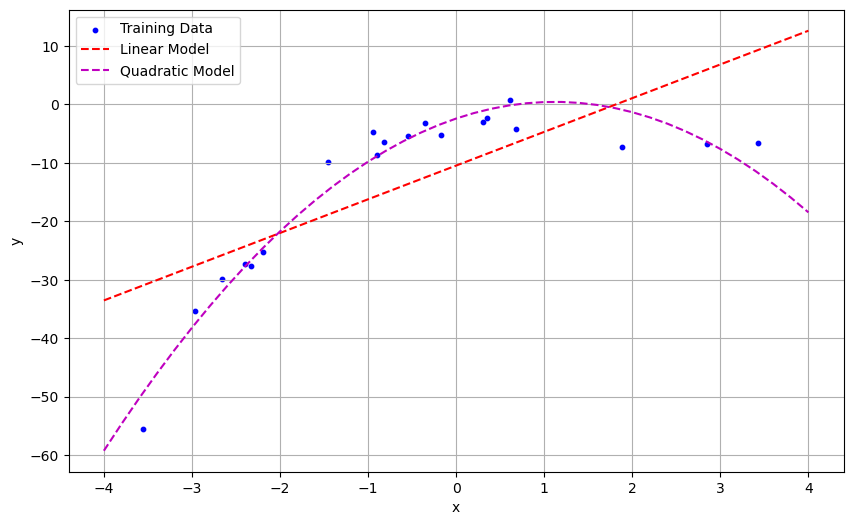

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], label='Training Data', color='b', s=10)
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad01'], label = 'Linear Model', linestyle="--", color='r')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad02'], label = 'Quadratic Model', linestyle="--", color='m')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.grid()
plt.show()

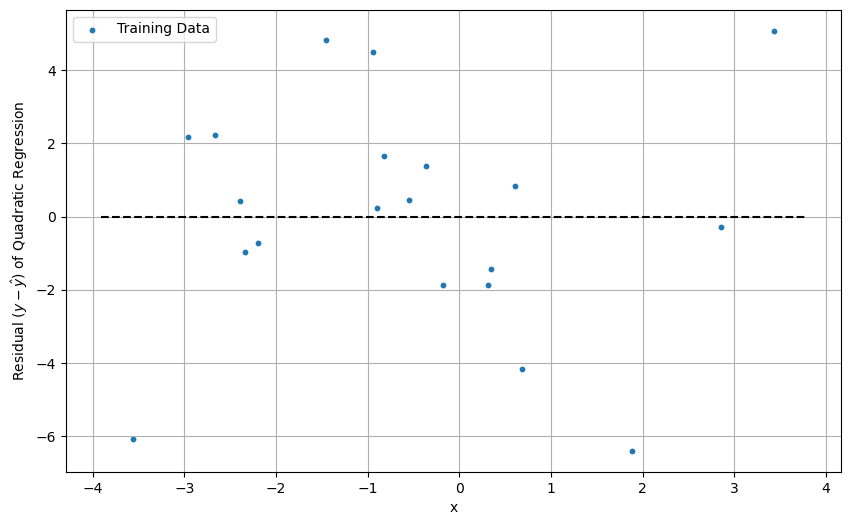

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], lm_grad02_pred_res_train['Residual'], label='Training Data', s=10)
plt.legend()

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('Residual ($y-\hat{y}$) of Quadratic Regression')

plt.plot(plt.xlim(), [0, 0], linestyle="--", color='k')
plt.grid()
plt.show()

## Qubic Regression
As before, we do the feature transformation by defining a further feature and then fit a linear regression with OLS (ordinary least squares):

**EXERCISE:** Analoguous to the quadratic regression above, do a regression with a polynomial of degree 3. Train and evaluate it.

In [ ]:
# polynomial_features03 = ...
# ...

**SOLUTION**:

In [29]:
polynomial_features03 = PolynomialFeatures(degree=3)
train_x_poly03 = polynomial_features03.fit_transform(train_x)
train_x_poly03_df = pd.DataFrame(train_x_poly03, columns=['x0', 'x1', 'x2', 'x3'])

In [30]:
model03 = LinearRegression()
model03.fit(train_x_poly03_df, train_y)
print_coeff_and_intercept(model03)

Model Coefficients: 
[[ 0.          2.00324893 -2.2111071   0.37440097]]
Intercept: 
[-3.25299142]


In [31]:
lm_grad03_pred_res_train = get_prediction_and_residuum(model03,
                                                       train_x_poly03_df,
                                                       data_train['y'].reset_index()['y'])

r2-Score: 0.9830589824656315
MSE: 3.4647475721007064
RMSE: 1.8613832415976852


**(END OF SOLUTION)**

Again we plot the models and the data:

In [32]:
data_forPlot_3 = polynomial_features03.fit_transform(data_forPlot[['x']])
data_forPlot_3_df = pd.DataFrame(data_forPlot_3, columns=['x0', 'x1', 'x2', 'x3'])
data_forPlot['y_lm_grad03'] = model03.predict(data_forPlot_3_df)

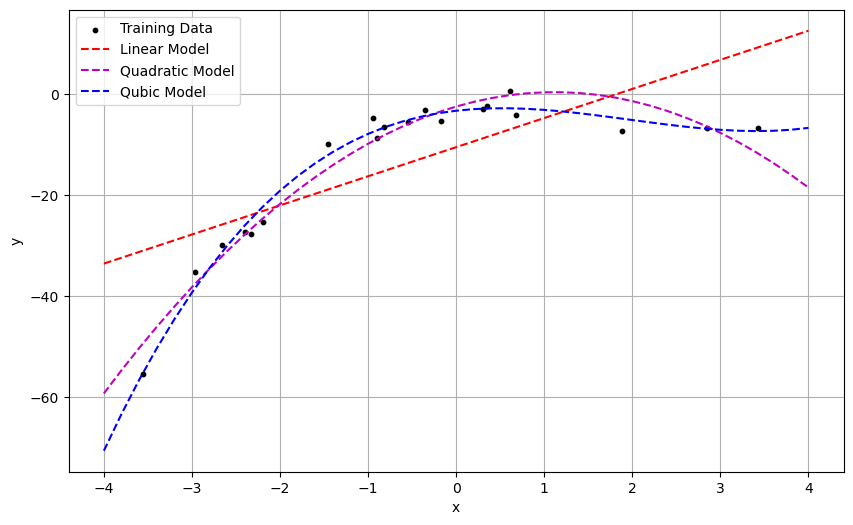

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], 
            label='Training Data', color='k', s=10)
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad01'], label = 'Linear Model', linestyle="--", color='r')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad02'], label = 'Quadratic Model', linestyle="--", color='m')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad03'], label = 'Qubic Model', linestyle="--", color='b')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.grid()
plt.show()

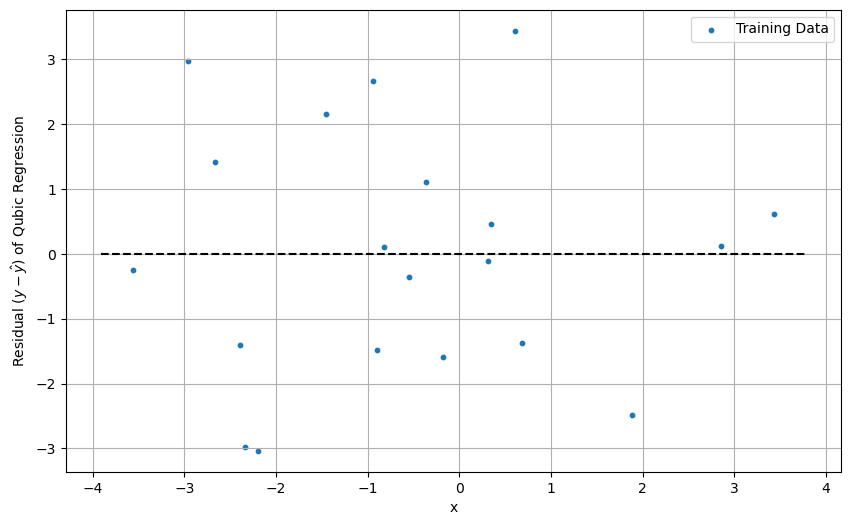

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], lm_grad03_pred_res_train['Residual'], label='Training Data', s=10)
plt.legend()

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('Residual ($y-\hat{y}$) of Qubic Regression')

plt.plot(plt.xlim(), [0, 0], linestyle="--", color='k')
plt.grid()
plt.show()

## Polynomial Regression, Degree 4:

In [35]:
polynomial_features04 = PolynomialFeatures(degree=4)
train_x_poly04 = polynomial_features04.fit_transform(train_x)
train_x_poly04_df = pd.DataFrame(train_x_poly04, columns=['x0', 'x1', 'x2', 'x3', 'x4'])

In [36]:
model04 = LinearRegression()
model04.fit(train_x_poly04_df, train_y)

LinearRegression()

In [37]:
print_coeff_and_intercept(model04)

Model Coefficients: 
[[ 0.          1.72144156 -2.63199186  0.40126689  0.03862222]]
Intercept: 
[-2.92505534]


In [38]:
data_forPlot_4 = polynomial_features04.fit_transform(data_forPlot[['x']])
data_forPlot_4_df = pd.DataFrame(data_forPlot_4, columns=['x0', 'x1', 'x2', 'x3', 'x4'])
data_forPlot['y_lm_grad04'] = model04.predict(data_forPlot_4_df)

In [39]:
lm_grad04_pred_res_train = get_prediction_and_residuum(model04,
                                                       train_x_poly04_df,
                                                       data_train['y'].reset_index()['y'])

r2-Score: 0.9842678067046756
MSE: 3.217520931857405
RMSE: 1.7937449461552233


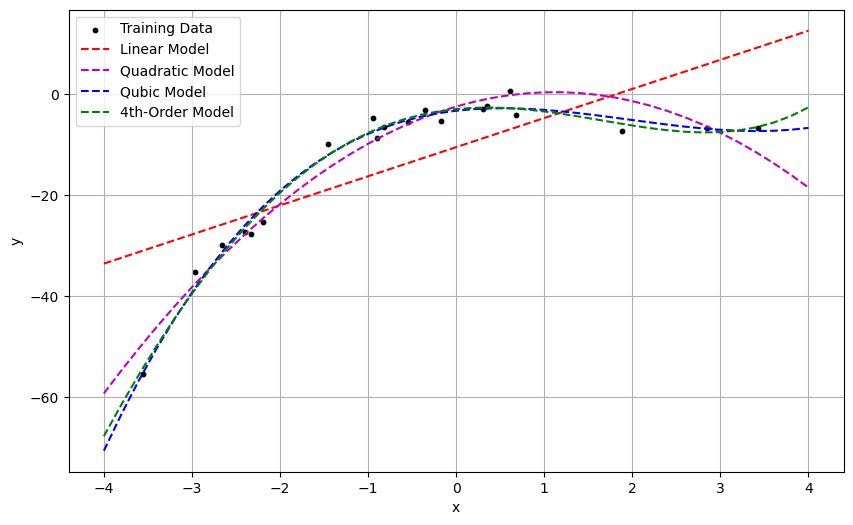

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], 
            label='Training Data', color='k', s=10)
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad01'], label = 'Linear Model', linestyle="--", color='r')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad02'], label = 'Quadratic Model', linestyle="--", color='m')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad03'], label = 'Qubic Model', linestyle="--", color='b')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad04'], label = '4th-Order Model', linestyle="--", color='g')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.grid()
plt.show()

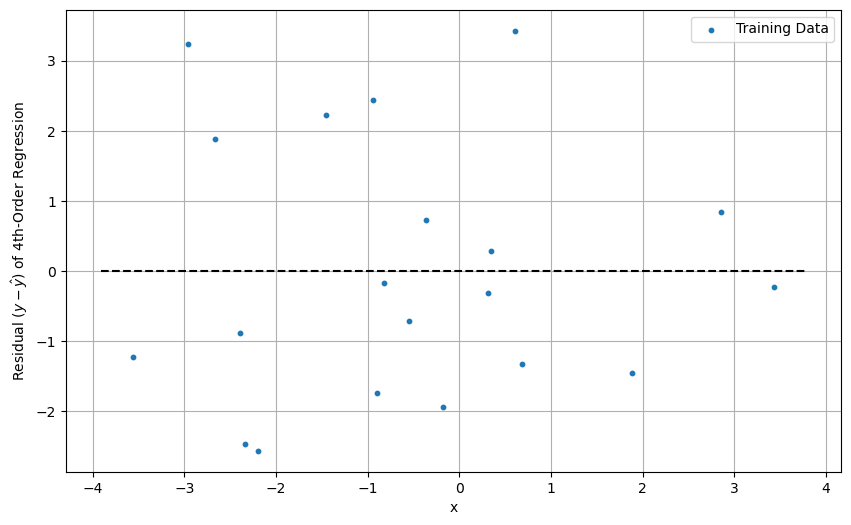

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], lm_grad04_pred_res_train['Residual'], label='Training Data', s=10)
plt.legend()

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('Residual ($y-\hat{y}$) of 4th-Order Regression')

plt.plot(plt.xlim(), [0, 0], linestyle="--", color='k')
plt.grid()
plt.show()

The difference to the qubic regression (both with respect to the model predictions and the residui.

## Polynomial Regression with Degree 20

**EXERCISE:** Analoguous to the examples above, do a regression with a polynomial of degree 20. Train and evaluate it. What do you think about it?

In [ ]:
# prepare data
# polynomial_features20 = ...
# train_x_poly20 = ...
# train_x_poly20_df = ...

**SOLUTION:**

In [42]:
# prepare data
polynomial_features20 = PolynomialFeatures(degree=20)
train_x_poly20 = polynomial_features20.fit_transform(train_x)
train_x_poly20_df = pd.DataFrame(train_x_poly20)

In [43]:
# define model, ...
model20 = LinearRegression()
# ..., train, ...
model20.fit(train_x_poly20_df, train_y)
# ... evaluate results on training data:
lm_grad20_pred_res_train = get_prediction_and_residuum(model20, train_x_poly20_df, data_train['y'].reset_index()['y'])

r2-Score: 0.9999982701908757
MSE: 0.0003537775668656321
RMSE: 0.018808975699533246


looks good!? Let's see:

In [44]:
x_forPlot_detail = np.linspace(-5, 5, num=50001).reshape(-1, 1)
x_forPlot_detail_p20 = polynomial_features20.fit_transform(x_forPlot_detail)

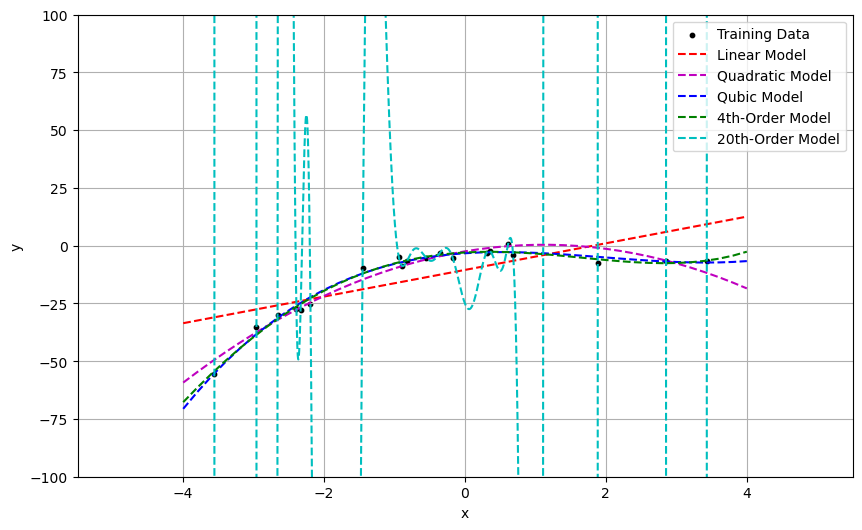

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(data_train['x'], data_train['y'], 
            label='Training Data', color='k', s=10)
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad01'], label = 'Linear Model', linestyle="--", color='r')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad02'], label = 'Quadratic Model', linestyle="--", color='m')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad03'], label = 'Qubic Model', linestyle="--", color='b')
plt.plot(data_forPlot['x'], data_forPlot['y_lm_grad04'], label = '4th-Order Model', linestyle="--", color='g')
plt.plot(x_forPlot_detail, model20.predict(x_forPlot_detail_p20), label = '20th-Order Model', linestyle="--", color='c')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.ylim(-100, 100)

plt.grid()
plt.show()

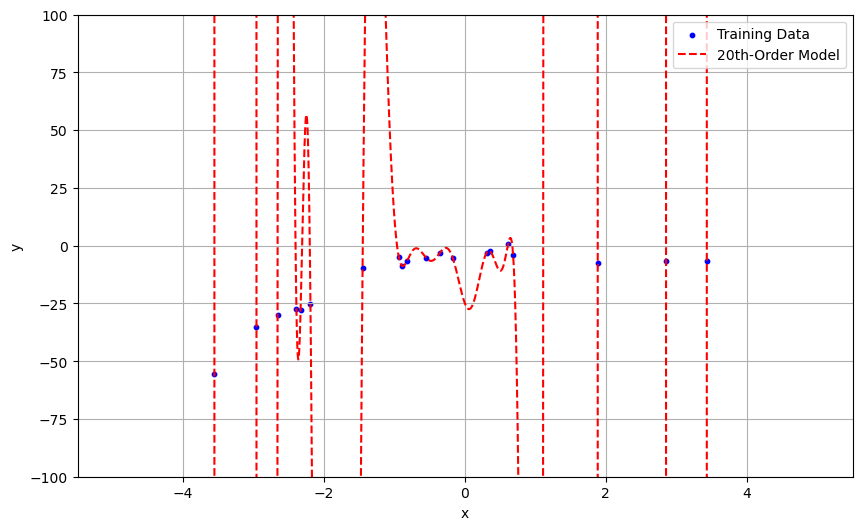

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

plt.scatter(data_train['x'], data_train['y'], 
            label='Training Data', color='b', s=10)
plt.plot(x_forPlot_detail, model20.predict(x_forPlot_detail_p20),
         label = '20th-Order Model',
         linestyle="--", color='r')

plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.ylim(-100, 100)

plt.grid()
plt.show()

Looking at the plot, a minimal change on `x` will lead to a huge change on the `y` axis; the `y` values fluctuate widely. This makes no sense!

**(END OF SOLUTION)**

For a better understanding, let's look at the parameters of the model, and compare them with some parameters we got for models of lower degree:

In [47]:
print_coeff_and_intercept(model20)

Model Coefficients: 
[[ 4.43361702e+03 -7.72941272e+01  5.61611996e+02  1.65133172e+03
  -4.46636845e+03 -1.25365938e+04  1.21912645e+04  4.18383060e+04
  -4.75913751e+03 -6.25047107e+04 -2.31003520e+04  3.60377805e+04
   2.60139901e+04 -4.35406703e+03 -8.20821884e+03 -1.31787214e+03
   8.20928367e+02  2.84925992e+02 -7.79993348e+00 -1.36392288e+01
  -1.48028652e+00]]
Intercept: 
[-4458.73709081]


In [48]:
print_coeff_and_intercept(model02)

Model Coefficients: 
[[ 0.          5.09643632 -2.27730563]]
Intercept: 
[-2.4263625]


The parameters in `model20` are much larger. In addition, the degree of the polynomial is high! $x^{20}$ grows incredibly quickly!

In [49]:
np.array([0.0, 1.0, 2.0, 3.0, 4.0])**20

array([0.00000000e+00, 1.00000000e+00, 1.04857600e+06, 3.48678440e+09,
       1.09951163e+12])

$4^{20}$ is already over a trillion (one million million). At the same time, ${(1/4)}^{20}$ is less than a trillionth. With such different values, the computer reaches its limits, resulting in so-called *numerical instabilities*. Incidentally, these are also the reason why the regression does not go through all the points exactly.

## Learning as Generalization: Systematic Performance Comparison on Training and Test Data
We now want to look at the performance of models with different degrees on the training and test data. First, we sketch our program in pseudo-code:

In [50]:
# Create training and test dataset.
# (generate or split given dataset)

# for different degrees of model - from degree 1 to 10
    # Prepare data: e.g. polynomial features of degree 7

    # Define model of selected degree

    # Train model with training data

    # Measure R-squared and RMSE (root mean squared error)
    # on TRAINING and TEST DATA!!

We also write an output function for the root mean square error and the R-squared coefficient:

In [51]:
def get_rmse_r2(true_y, pred_y, doPrint=False):
    rmse = np.sqrt(mean_squared_error(true_y, pred_y))
    r2 = r2_score(true_y, pred_y)
    
    if doPrint:
        print("Mean Squared Error (RMSE): " + str(rmse))
        print("R-squared: " + str(r2))
        
    return [rmse, r2]

Now we are ready to implement the systematic performance comparison:

In [52]:
# prepare arrays to store performance results
train_performance = np.array([])
test_performance = np.array([])
max_degree = 10

# for different degrees of model - from degree 1 to 10
for degree in range(0, max_degree):

    # Prepare data: e.g. polynomial features of degree 7
    polynomial_features = PolynomialFeatures(degree=degree)
    train_x_poly = polynomial_features.fit_transform(train_x)
    
    # Define model of selected degree
    model = LinearRegression()

    # Train model with training data
    model.fit(train_x_poly, train_y)

    # Measure R-squared and RMSE (root mean squared error)
    # - on training data:
    train_y_pred = model.predict(train_x_poly)
    train_performance = np.append(train_performance, 
                                  get_rmse_r2(train_y, train_y_pred),
                                  axis=0)
    
    #  Measure R-squared and RMSE (root mean squared error)
    # - on test data:
    test_x_poly = polynomial_features.fit_transform(test_x)
    test_y_pred = model.predict(test_x_poly)
    test_performance = np.append(test_performance,
                                 get_rmse_r2(test_y, test_y_pred),
                                 axis=0)
    
train_performance = train_performance.reshape(-1, 2)
test_performance = test_performance.reshape(-1, 2)

With `append(test_performance, get_rmse_r2(test_y, test_y_pred), axis=0)` the new results that we receive via the function `get_rmse_r2(test_y, test_y_pred)` are appended to the existing array.

Finally, it is transformed into a two-dimensional structure with `train_performance = train_performance.reshape(-1, 2)` and `test_performance = test_performance.reshape(-1, 2)`.

Next, we create a graph to plot the mean square error or R-score as a function of the polynomial degree:

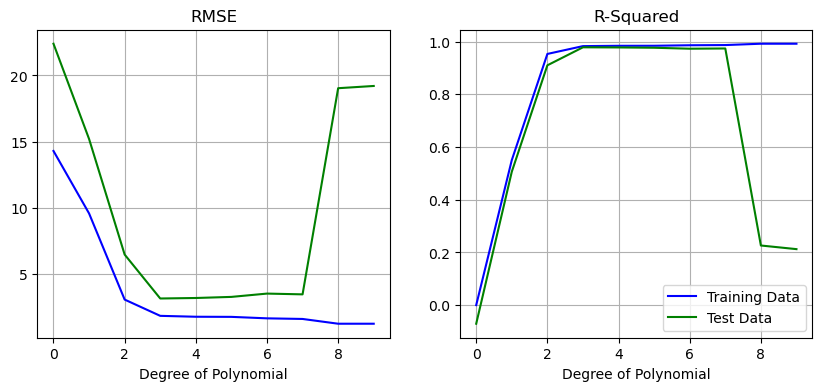

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(range(0, max_degree), train_performance[:, 0], color='b',
           label='Training Data')
ax[0].plot(range(0, max_degree), test_performance[:, 0], color='g',
           label='Test Data')
ax[0].grid()
ax[0].set_title('RMSE')
ax[0].set_xlabel('Degree of Polynomial')

ax[1].plot(range(0, max_degree), train_performance[:, 1], color='b',
           label='Training Data')
ax[1].plot(range(0, max_degree), test_performance[:, 1], color='g',
           label='Test Data')
ax[1].grid()
ax[1].set_title('R-Squared')
ax[1].set_xlabel('Degree of Polynomial')

plt.legend()
plt.show()

We can thus adapt the model complexity to the test data. With a polynomial of degree 4 we achieve the best quality in terms of both quality measures (RMSE and R-Squared). The appropriate degree for the polynomial regression is therefore 4.

**BUT**: we have now determined the model complexity using the test data... and we may also be overfitting! So we need a third, separate data set to determine the final quality.

### Crossvalidation
We now use crossvalidation to first determine the model complexity and then - for the model of the selected complexity - to be able to make a final statement about the quality of the regression.

In the `sklean` library there is a function `cross_validate` which handles the crossvalidation. The function requires
* a model that implements the functions `fit()` and `predict`
* the independent variables of a training data set
* the dependent variables of the training data set
* `cv`, the number of runs
* `scoring`, the quality measures to be used

Details of the function can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
Note that the quality measures are always chosen according to convention so that more is better. R-Square has this property and is offered as `'explained_variance'`. With RMSE, however, less is better; here the negative RMSE is therefore implemented as `'neg_root_mean_squared_error'` as a quality measure. Details: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [54]:
from sklearn.model_selection import cross_validate

In [55]:
polynomial_features = PolynomialFeatures(degree=3)
train_x_poly = polynomial_features.fit_transform(train_x)

model = LinearRegression()
cv_result = cross_validate(model, train_x_poly, train_y, cv=5, 
                           scoring=('explained_variance', 'neg_root_mean_squared_error'),
                           return_train_score=True)

The resulting `cv_result` contains the metrics for every one of the cross-validation folds - i.e., 5 values in our case:

In [56]:
cv_result

{'fit_time': array([0., 0., 0., 0., 0.]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_explained_variance': array([0.97188122, 0.99290414, 0.98703251, 0.51426089, 0.92999929]),
 'train_explained_variance': array([0.98512912, 0.97126313, 0.98316357, 0.98596448, 0.98960188]),
 'test_neg_root_mean_squared_error': array([-2.25602527, -1.86012717, -2.42649864, -2.33855686, -3.06618648]),
 'train_neg_root_mean_squared_error': array([-1.83085781, -1.94449041, -1.82369666, -1.83402974, -1.51713745])}

Technically, the result `cv_result` is a dictionary, where each value is an array with the respective measurements for every cross-validation fold. Hence, we can for example compute the mean and standard deviation over all cross-validation folds:

In [57]:
for name, valarr in cv_result.items():
    print(name + ": " + '{:.4}'.format(np.mean(valarr)) + "+-" + '{:.4}'.format(np.std(valarr)))

fit_time: 0.0+-0.0
score_time: 0.0+-0.0
test_explained_variance: 0.8792+-0.1838
train_explained_variance: 0.983+-0.00624
test_neg_root_mean_squared_error: -2.389+-0.3899
train_neg_root_mean_squared_error: -1.79+-0.1436


### Running Cross-Validation for Varying Polynom Degree
Next, we run the cross-validation for polynomial regression models with varying degree:

In [58]:
train_performance_rms_mean = np.zeros(max_degree)
train_performance_rms_mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
overall_train_x = train_x
overall_train_y = train_y

In [60]:
# Initialise arrays
max_degree = 10

train_performance_rms_mean = np.zeros(max_degree+1)
train_performance_r2_mean = np.zeros(max_degree+1)
train_performance_rms_std = np.zeros(max_degree+1)
train_performance_r2_std = np.zeros(max_degree+1)

val_performance_rms_mean = np.zeros(max_degree+1)
val_performance_r2_mean = np.zeros(max_degree+1)
val_performance_rms_std = np.zeros(max_degree+1)
val_performance_r2_std = np.zeros(max_degree+1)

# for-loop:
for degree in range(0, max_degree+1):
    # genearte polynomial features 
    polynomial_features = PolynomialFeatures(degree=degree)
    overall_train_x_poly = polynomial_features.fit_transform(overall_train_x)
    
    # define model and train via cross-validation
    model = LinearRegression()
    cv_result = cross_validate(model, overall_train_x_poly, overall_train_y, cv=5,
                               scoring=('explained_variance', 'neg_root_mean_squared_error'),
                               return_train_score=True)

    # summarize evaluation on training data
    train_performance_rms_mean[degree] = -np.mean(cv_result['train_neg_root_mean_squared_error'])
    train_performance_rms_std[degree]  = np.std(-cv_result['train_neg_root_mean_squared_error'])

    train_performance_r2_mean[degree] = np.mean(cv_result['train_explained_variance'])
    train_performance_r2_std[degree]  = np.std(cv_result['train_explained_variance'])

    # summarize evaluation on validation data
    val_performance_rms_mean[degree] = -np.mean(cv_result['test_neg_root_mean_squared_error'])
    val_performance_rms_std[degree]  =  np.std(-cv_result['test_neg_root_mean_squared_error'])

    val_performance_r2_mean[degree] = np.mean(cv_result['test_explained_variance'])
    val_performance_r2_std[degree]  = np.std(cv_result['test_explained_variance'])

Let's again plot the performance metrics versus the degree of the polynomial:

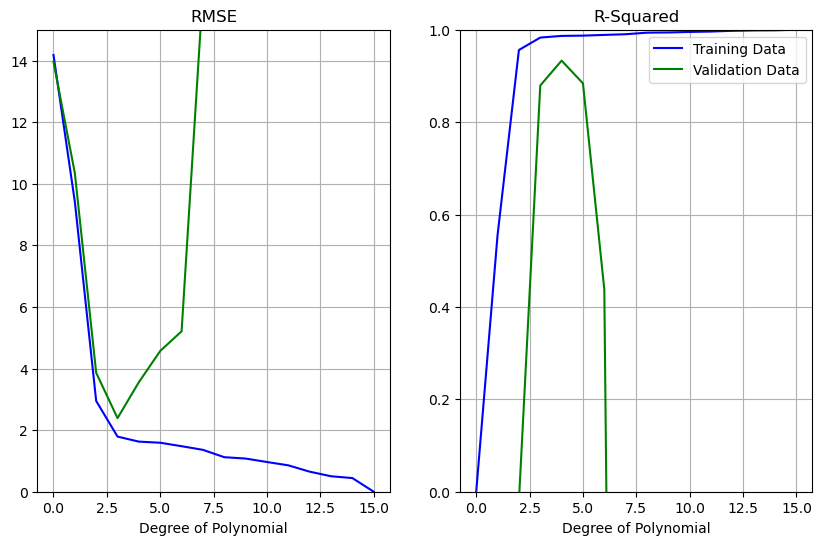

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].plot(range(0, max_degree+1), train_performance_rms_mean, color='b', label='Training Data')
ax[0].plot(range(0, max_degree+1), val_performance_rms_mean, color='g', label='Validation Data')
ax[0].set_title('RMSE')
ax[0].set_ylim(0, 15)
ax[0].grid()
ax[0].set_xlabel('Degree of Polynomial')


ax[1].plot(range(0, max_degree+1), train_performance_r2_mean, color='b', label='Training Data')
ax[1].plot(range(0, max_degree+1), val_performance_r2_mean, color='g', label='Validation Data')
ax[1].set_title('R-Squared')
ax[1].set_ylim(0, 1)
ax[1].grid()
ax[1].set_xlabel('Degree of Polynomial')

plt.legend()
plt.show()

Note that the curves are now different from the ones we obtained above. 

**TODO:** Explain why.

**SOLUTION**: we have split the training data used above into training and validation data. Hence, from the original 20 data in `train_x` used above, we now only use 80% for training, and the remaining 20% for evaluation. Hence, the training data consists of only 16 samples.

**END OF SOLUTION**

We extend the plot to include the standard deviation of the performance metrics over the 5 cross-validation sets:

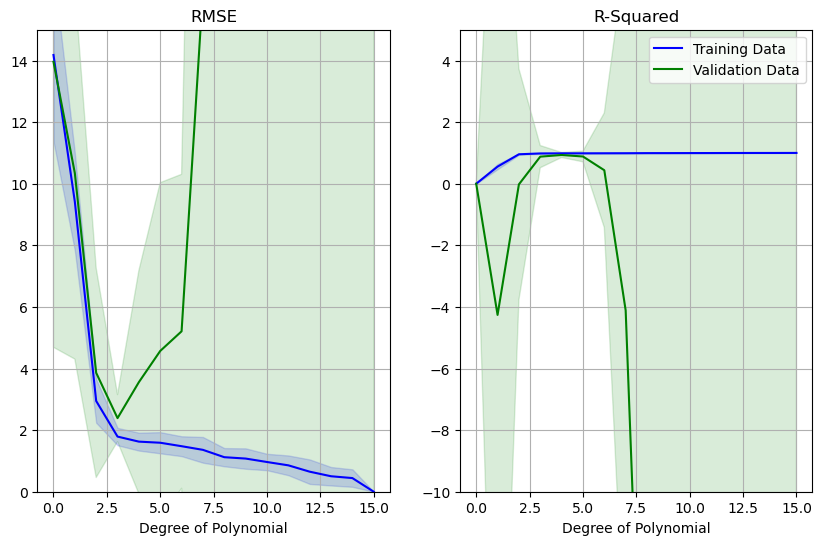

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

train_performance_rms_mean = np.array(train_performance_rms_mean)
train_performance_rms_std = np.array(train_performance_rms_std)

ax[0].plot(range(0, max_degree+1), train_performance_rms_mean, color='b', label='Training Data')
ax[0].fill_between(range(0, max_degree+1), train_performance_rms_mean-1.96*train_performance_rms_std,
                         train_performance_rms_mean+1.96*train_performance_rms_std, color='b', alpha=.15)
ax[0].plot(range(0, max_degree+1), val_performance_rms_mean, color='g', label='Validation Data')
ax[0].fill_between(range(0, max_degree+1), val_performance_rms_mean-1.96*val_performance_rms_std,
                         val_performance_rms_mean+1.96*val_performance_rms_std, color='g', alpha=.15)

ax[0].set_title('RMSE')
ax[0].set_ylim(0, 15)
ax[0].grid()
ax[0].set_xlabel('Degree of Polynomial')

ax[1].plot(range(0, max_degree+1), train_performance_r2_mean, color='b', label='Training Data')
ax[1].fill_between(range(0, max_degree+1), train_performance_r2_mean-1.96*train_performance_r2_std,
                         train_performance_r2_mean+1.96*train_performance_r2_std, color='b', alpha=.15)
ax[1].plot(range(0, max_degree+1), val_performance_r2_mean, color='g', label='Validation Data')
ax[1].fill_between(range(0, max_degree+1), val_performance_r2_mean-1.96*val_performance_r2_std,
                         val_performance_r2_mean+1.96*val_performance_r2_std, color='g', alpha=.15)

ax[1].set_title('R-Squared')
ax[1].set_ylim(-10, 5)
ax[1].grid()
ax[1].set_xlabel('Degree of Polynomial')

plt.legend()
plt.show()

## Grid Search
As hyperparameter optimization is a very common task, the `scikit-learn` framework offers the `GridSearchCV` class to systematically evaluate a grid of hyperparameters using crossvalidation in order to find the best set of hyperparameters. To make use of the function, one typically defines a so-called `Pipeline`, which comprises all steps including e.g. preprocessing. Also, a grid of all hyperparameters to be evaluated has to be passed; the `fit` function will then determine the best hyperparameter tuple based on a training data set, doing crossvalidation internally.

In [63]:
from sklearn.pipeline import Pipeline
def PolynomialRegression(degree=2, **kwargs):
    return Pipeline(steps=[('polyfeat', PolynomialFeatures()), ('regression', LinearRegression())])

In [64]:
poly_grid = GridSearchCV(PolynomialRegression(), param_grid={'polyfeat__degree': range(0, max_degree+1)}, 
                         cv=10, 
                         scoring='neg_mean_squared_error', 
                         verbose=3) 

In [65]:
poly_grid.fit(train_x, train_y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END .............polyfeat__degree=0;, score=-94.138 total time=   0.0s
[CV 2/10] END ............polyfeat__degree=0;, score=-147.714 total time=   0.0s
[CV 3/10] END ............polyfeat__degree=0;, score=-978.694 total time=   0.0s
[CV 4/10] END .............polyfeat__degree=0;, score=-77.630 total time=   0.0s
[CV 5/10] END ............polyfeat__degree=0;, score=-270.114 total time=   0.0s
[CV 6/10] END ............polyfeat__degree=0;, score=-196.826 total time=   0.0s
[CV 7/10] END .............polyfeat__degree=0;, score=-41.155 total time=   0.0s
[CV 8/10] END .............polyfeat__degree=0;, score=-86.060 total time=   0.0s
[CV 9/10] END ............polyfeat__degree=0;, score=-154.617 total time=   0.0s
[CV 10/10] END ...........polyfeat__degree=0;, score=-139.684 total time=   0.0s
[CV 1/10] END .............polyfeat__degree=1;, score=-42.843 total time=   0.0s
[CV 2/10] END .............polyfeat__degree=1;

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polyfeat', PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polyfeat__degree': range(0, 16)},
             scoring='neg_mean_squared_error', verbose=3)

In [66]:
poly_grid.cv_results_

{'mean_fit_time': array([0.00045254, 0.00156412, 0.00312407, 0.        , 0.00155916,
        0.00055084, 0.00156357, 0.00244625, 0.00075116, 0.00155075,
        0.00156291, 0.00156519, 0.00221043, 0.        , 0.00157428,
        0.00156252]),
 'std_fit_time': array([0.00135763, 0.00469236, 0.00624815, 0.        , 0.00467749,
        0.00165253, 0.00469072, 0.00485513, 0.00087192, 0.00465224,
        0.00468872, 0.00469558, 0.00486626, 0.        , 0.00472283,
        0.00468757]),
 'mean_score_time': array([0.00156431, 0.0016027 , 0.        , 0.00157313, 0.        ,
        0.00105104, 0.00157225, 0.00047908, 0.00010004, 0.00160134,
        0.        , 0.        , 0.0015624 , 0.00096157, 0.00156248,
        0.        ]),
 'std_score_time': array([0.00469294, 0.00480809, 0.        , 0.0047194 , 0.        ,
        0.00315313, 0.00471675, 0.00048174, 0.00030012, 0.00480402,
        0.        , 0.        , 0.00468721, 0.0028847 , 0.00468743,
        0.        ]),
 'param_polyfeat__degree':

In [67]:
poly_grid.best_params_

{'polyfeat__degree': 3}

In [68]:
poly_grid.best_estimator_

Pipeline(steps=[('polyfeat', PolynomialFeatures(degree=3)),
                ('regression', LinearRegression())])

In [69]:
poly_grid.fit(train_x, train_y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END .............polyfeat__degree=0;, score=-94.138 total time=   0.0s
[CV 2/10] END ............polyfeat__degree=0;, score=-147.714 total time=   0.0s
[CV 3/10] END ............polyfeat__degree=0;, score=-978.694 total time=   0.0s
[CV 4/10] END .............polyfeat__degree=0;, score=-77.630 total time=   0.0s
[CV 5/10] END ............polyfeat__degree=0;, score=-270.114 total time=   0.0s
[CV 6/10] END ............polyfeat__degree=0;, score=-196.826 total time=   0.0s
[CV 7/10] END .............polyfeat__degree=0;, score=-41.155 total time=   0.0s
[CV 8/10] END .............polyfeat__degree=0;, score=-86.060 total time=   0.0s
[CV 9/10] END ............polyfeat__degree=0;, score=-154.617 total time=   0.0s
[CV 10/10] END ...........polyfeat__degree=0;, score=-139.684 total time=   0.0s
[CV 1/10] END .............polyfeat__degree=1;, score=-42.843 total time=   0.0s
[CV 2/10] END .............polyfeat__degree=1;

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polyfeat', PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polyfeat__degree': range(0, 16)},
             scoring='neg_mean_squared_error', verbose=3)

In [70]:
test_y_pred = poly_grid.predict(test_x)

In [71]:
get_rmse_r2(test_y, test_y_pred, doPrint=False)

[3.1706584391399315, 0.978532259967811]

## Statistical Model Selection
After looking at the prediction performance on new data, let's focus on the statistical model selection, which is based on calculations on the training data.

In order to dive deeper into linear Regression, we will use a more specialized library, called `statsmodels`, which we also already imported as `smf`. This library has a class `ols` (for *ordinary least squares*, as we have already seen). We start with a simple linear regression model, aiming to predict `y` based on `x`:

In [72]:
# define model
lm_grad01 = smf.ols('y ~ x', data=data_train)

# train / "fit" the model
lm_grad01_fitted = lm_grad01.fit()

The `summary` method gives a comprehensive overview over the model and its performance on the training data (see lecture slides for details):

In [73]:
lm_grad01_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     22.04
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           0.000181
Time:                        14:21:01   Log-Likelihood:                -73.591
No. Observations:                  20   AIC:                             151.2
Df Residuals:                      18   BIC:                             153.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.4721      2.362     -4.433      0.000     -15.435      -5.510
x              5.7665      1.228      4.694      0.000       3.186       8.347
==============================================================================
Omnibus:                        4.087   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                2.833
Skew:                          -0.922   Prob(JB):                        0.243
Kurtosis:                       3.005   Cond. No.                         2.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We continue with a quadratic regression model:

In [74]:
data_train['x2'] = data_train['x']**2
lm_grad02 = smf.ols('y ~ x + x2 ', data=data_train)
lm_grad02_fitted = lm_grad02.fit()

lm_grad02_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     173.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           4.84e-12
Time:                        14:21:01   Log-Likelihood:                -50.934
No. Observations:                  20   AIC:                             107.9
Df Residuals:                      17   BIC:                             110.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4264      1.027     -2.364      0.030      -4.592      -0.261
x              5.0964      0.411     12.403      0.000       4.230       5.963
x2            -2.2773      0.188    -12.118      0.000      -2.674      -1.881
==============================================================================
Omnibus:                        0.756   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.480
Skew:                          -0.363   Prob(JB):                        0.787
Kurtosis:                       2.781   Cond. No.                         7.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The cubic regression model:

In [75]:
data_train['x3'] = data_train['x']**3
lm_grad03 = smf.ols('y ~ x + x2 + x3', data=data_train)
lm_grad03_fitted = lm_grad03.fit()

In [76]:
lm_grad03_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     309.5
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           2.25e-14
Time:                        14:21:01   Log-Likelihood:                -40.805
No. Observations:                  20   AIC:                             89.61
Df Residuals:                      16   BIC:                             93.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2530      0.656     -4.955      0.000      -4.645      -1.861
x              2.0032      0.637      3.143      0.006       0.652       3.354
x2            -2.2111      0.117    -18.834      0.000      -2.460      -1.962
x3             0.3744      0.071      5.297      0.000       0.225       0.524
==============================================================================
Omnibus:                        0.690   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.671
Skew:                           0.142   Prob(JB):                        0.715
Kurtosis:                       2.149   Cond. No.                         26.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comment**: We see that as we increase the polynomial degree from 1 to 3, all parameters are significant, and the performance (measured e.g. in the R-squared score) increases.

Now, let's see what happens if we define a polynomial regression model of degree 4:

In [77]:
data_train['x4'] = data_train['x']**4
lm_grad04 = smf.ols('y ~ x + x2 + x3 + x4', data=data_train)
lm_grad04_fitted = lm_grad04.fit()

lm_grad04_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     234.6
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           2.51e-13
Time:                        14:21:01   Log-Likelihood:                -40.065
No. Observations:                  20   AIC:                             90.13
Df Residuals:                      15   BIC:                             95.11
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9251      0.721     -4.056      0.001      -4.462      -1.388
x              1.7214      0.686      2.508      0.024       0.258       3.185
x2            -2.6320      0.409     -6.434      0.000      -3.504      -1.760
x3             0.4013      0.075      5.374      0.000       0.242       0.560
x4             0.0386      0.036      1.074      0.300      -0.038       0.115
==============================================================================
Omnibus:                        1.829   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.407
Skew:                           0.470   Prob(JB):                        0.495
Kurtosis:                       2.103   Cond. No.                         91.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comment**: As discussed in the slides, we see that the coefficient of `x4` is not significant. We will thus omit it, which gets us back to the polynomial regression up to degree 3.

Hence, based on the statistical analysis of only the training data, the ordinary least squares fitting was able to identify the correct degree of the polynomial, and detected that the degree-4 contribution is not improving for the performance.

## Regularization
As a further way to do model selection, we look at regularization. We will use regularisation to determine the best degree for the polynomial regression.

First we have to scale the predictor variables. We do so using the `StandardScaler` from `sklearn.preprocessing`:

In [78]:
poly20_scaler = StandardScaler()
poly20_scaler = poly20_scaler.fit(train_x_poly20)
train_x_poly20_std = poly20_scaler.transform(train_x_poly20)

We start with a (randomly chosen) hyperparameter value of 0.1 (note that the hyperparameter is called `alpha` in scikit-learn, unlike in most of the literature):

In [79]:
lasso_model = Lasso(0.1)

In [80]:
lasso_model.fit(train_x_poly20_std, train_y)

Lasso(alpha=0.1)

We can get the coefficients. Note that we are doing multiple linear regression, i.e. we have a series of predictor variables - they are increasing powers of a single predictor variable, but the model does not know (nor need to know) about this. The first coefficient is the coefficient to the constant term $x^0$, then follows the coefficient to $x^1$, etc., until $x^20$:

In [81]:
lasso_model.coef_

array([ 0.        ,  3.96547341, -8.92811951,  5.56891086,  0.        ,
        0.        ,  0.18776813,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.42728904,
       -0.        ])

We see that with this weight for the penalty term, we have several non-zero coefficients:

In [82]:
np.where( np.abs(lasso_model.coef_) > 0)

(array([ 1,  2,  3,  6, 19], dtype=int64),)

The coefficients of $x^1$, $x^2$, $x^3$, $x^6$ and $x^19$ are all non-zero.

Let's try with a higher weight for the penalty term:

In [83]:
lasso_model = Lasso(alpha=0.5, max_iter=100000)
lasso_model.fit(train_x_poly20_std, train_y)
lasso_model.coef_

array([ 0.        ,  3.38211982, -8.46080479,  6.09097815, -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ])

In [84]:
np.where( np.abs(lasso_model.coef_) > 0)

(array([1, 2, 3], dtype=int64),)

Now, the lasso has indeed found the features that were used to generate the data.

## Grid Search for LASSO Parameter

In [85]:
model = Lasso(random_state = 0)

In [86]:
alpha_range = [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]

In [90]:
grid_search_r2 = GridSearchCV(model, param_grid={'alpha':alpha_range}, scoring ='r2', cv=5)
grid_search_r2.fit(train_x_poly20_std, train_y)

GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]},
             scoring='r2')

In [91]:
print('Scoring R2')
print('Best R2 score   : ', grid_search_r2.best_score_)
print('Best parameters : ', grid_search_r2.best_params_)

Scoring R2
Best R2 score   :  0.829147155185186
Best parameters :  {'alpha': 2}


In [94]:
lasso_model_r2 = Lasso(alpha = 2.0)
lasso_model_r2.fit(train_x_poly20_std, train_y)
lasso_model_r2.coef_

array([ 0.        ,  2.45702637, -7.15728991,  5.65554642, -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ])

In [92]:
grid_search_mse = GridSearchCV(model, param_grid={'alpha':alpha_range}, scoring ='neg_mean_squared_error', cv=5)
grid_search_mse.fit(train_x_poly20_std, train_y)

GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]},
             scoring='neg_mean_squared_error')

In [96]:
print('Scoring MSE')
print('Best MSE score   : ', -grid_search_mse.best_score_)
print('Best parameters  : ',  grid_search_mse.best_params_)

Scoring MSE
Best MSE score   :  7.746100132399246
Best parameters  :  {'alpha': 0.5}


In [95]:
lasso_model_mse = Lasso(alpha = 0.5)
lasso_model_mse.fit(train_x_poly20_std, train_y)
lasso_model_mse.coef_

array([ 0.        ,  3.38211982, -8.46080479,  6.09097815, -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ])

### Impact of the Tuning Parameter
Below we illustrate the impact of the tuning parameter $\alpha$. This is for illustration only, you don't need to understand the code in detail.

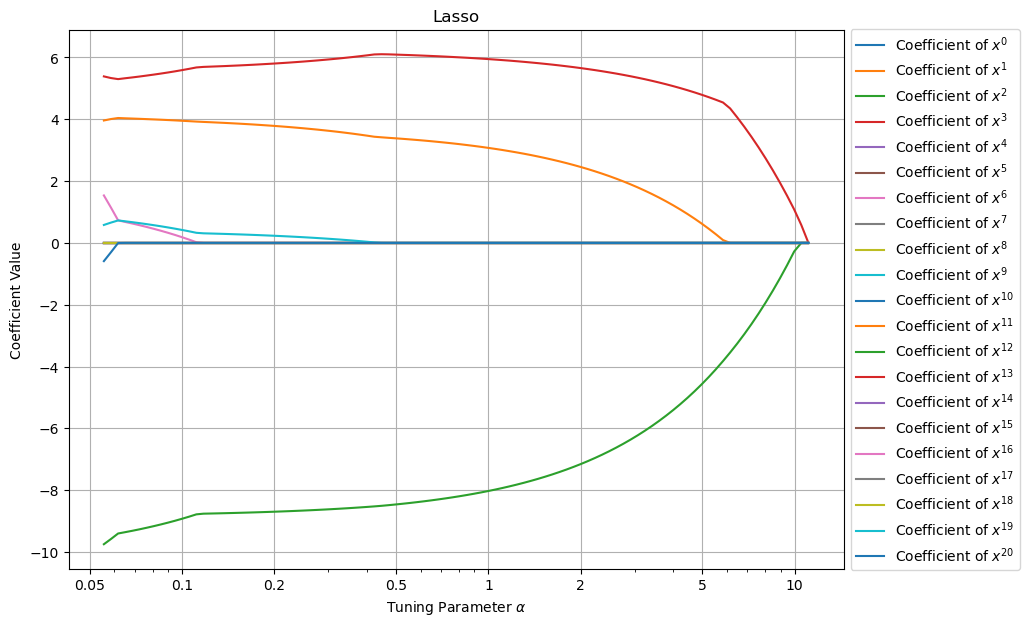

In [97]:
alphas_lasso, coefs_lasso, _ = lasso_path(train_x_poly20_std, train_y, eps=5e-3)

plt.figure(figsize = [10, 7])
for (degree, coef_l) in enumerate(coefs_lasso.squeeze()):
    l1 = plt.semilogx(alphas_lasso, coef_l, label=r'Coefficient of $x^{' + str(degree) + '}$')

plt.xlabel(r'Tuning Parameter $\alpha$')
plt.xticks(ticks=[0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10], labels=[0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])
plt.ylabel('Coefficient Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Lasso')
plt.grid()
plt.show()